In [2]:
import tensorflow as tf # models
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import datetime # manipulating dates
import os # accessing directory structure
import random # shuffling data
import cv2 # computer vision
import seaborn as sns # plotting
import sklearn # machine learning
from sklearn.model_selection import train_test_split # splitting data
from sklearn.metrics import confusion_matrix, roc_curve # model evaluation
from PIL import Image # manipulating images
import albumentations as A # data augmentation
import tensorflow_datasets as tfds # loading datasets
import tensorflow_probability as tfp # probabilistic models
from tensorflow.keras.models import Model # creating models
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling # creating layers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy # creating evaluation metrics
from tensorflow.keras.optimizers import Adam # optimizers
from tensorflow.keras.callbacks import Callback, CSVLogger,EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau # callbacks
from tensorflow.keras.regularizers import L1, L2 # regularization
from tensorboard.plugins.hparams import api as hp # hyperparameter tuning
print(tf.__version__)

2.18.1


### Wandb Install, Login, Initialization and Configuration

In [ ]:
# %pip install wandb


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import wandb

In [4]:
%wandb login

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from C:\Users\GROUP\_netrc.


In [5]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split='train')  # Use string instead of list

In [6]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# dataset.head()
for data in dataset.take(1):  # dataset is now directly the train split
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [8]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [9]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [10]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Dataset Visualization

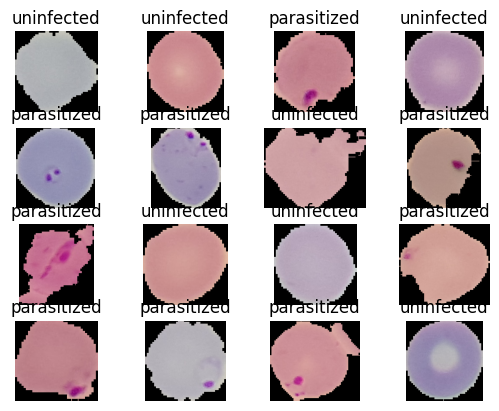

In [11]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

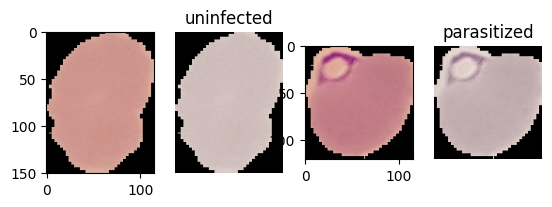

In [12]:
for i, (image, label) in enumerate(train_dataset.take(2)):
  plt.subplot(1, 4, 2*i + 1)
  plt.imshow(image)

  plt.subplot(1, 4, 2*i + 2)
  plt.imshow(tf.image.adjust_saturation(image, 0.3))


  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [13]:
dataset_info.features['label'].int2str(0)

'parasitized'

### Data Preprocessing

#### Data Augmentation

In [14]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [15]:
original_image, label = next(iter(train_dataset))

In [16]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)#central_crop(original_image, 0.8)

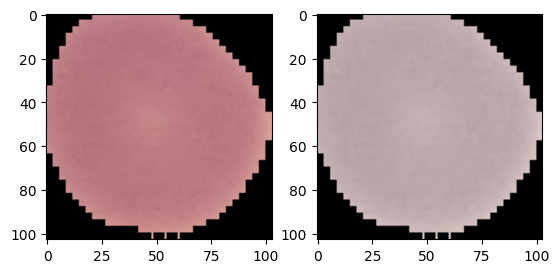

In [17]:
visualize(original_image, augmented_image)

In [18]:
IM_SIZE = 224

In [19]:
original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  #print("I was here")
  #tf.print("I was here")
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [20]:
tf.config.run_functions_eagerly(False)

In [21]:
### tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),                               
])

In [22]:
### tf.image augment
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [23]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()
    
  @tf.function
  def call(self, image):
    return tf.image.rot90(image)

In [24]:
# import RandomContrast
from tensorflow.keras.layers import RandomContrast

In [25]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
                                  
])

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

#### Data Loading

In [26]:
BATCH_SIZE = 32

In [27]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
#train_dataset

In [28]:
for image,label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [29]:
train_dataset = (
  train_dataset
  .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
  .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
  .batch(BATCH_SIZE)
  .prefetch(tf.data.AUTOTUNE)
)

In [30]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [31]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Mlxup Data Augmentation

In [33]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [34]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [35]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
    #map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [36]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>